# CNC SMS Prediction Autoregression Model

Иммется временной ряд отправленных СМС оповещений за 4 месяца в периодичнотью в 1 час.
Требуебся построить корректную авторегрессионную модель, выдать прогноз на n временных интервалов вперед и визуализировать результаты

In [68]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pylab as plt
import warnings
from itertools import product

pd.options.display.float_format = '{:.3f}'.format

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


Загрузим входные данные и выведем некотрые статистические показатели

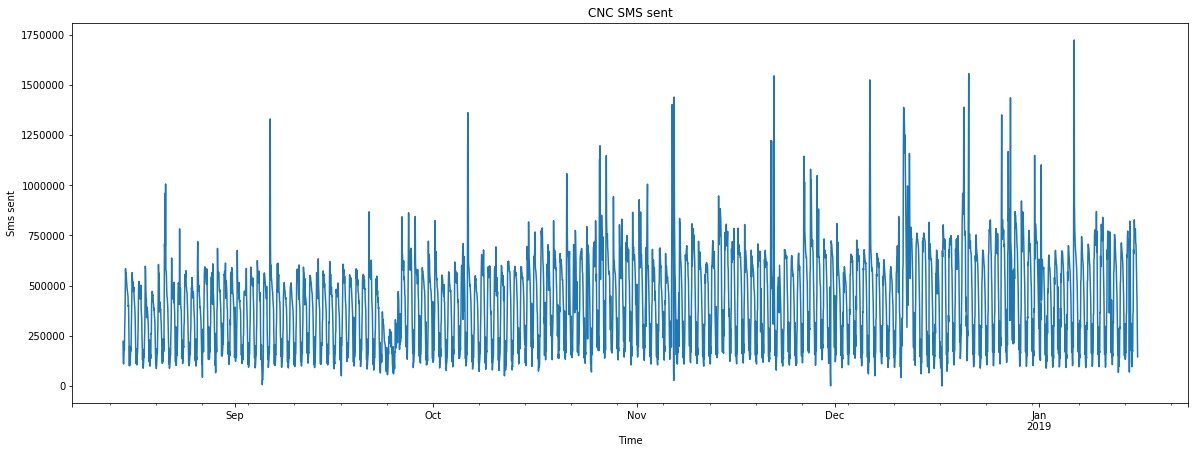

count      3696.000
mean     418958.306
std      230028.718
min           1.000
25%      205113.250
50%      422540.000
75%      586407.250
max     1722850.000
Name: Value, dtype: float64

In [87]:
df = pd.read_csv('every_hour.csv', sep=';', index_col=['Time'], parse_dates=['Time'], dayfirst=True)
df = df.drop(df['Value'].tail(1).index)
n = int(df['Value'].size/2)
df = df[n:]
df['Value'] = df['Value'].apply(lambda text: ''.join(j for j in text if ord(j) < 128))
df['Value'] = df['Value'].apply(lambda val: float(val))
df['Value'] = df['Value'].apply(lambda val: 1 if val <= 0 else val)
df['Value'] = df['Value'].asfreq('10min')
data = df['Value']
plt.figure(figsize(20,7))
data.plot()
plt.title("CNC SMS sent")
plt.ylabel('Sms sent')
plt.show()
    
data.describe()

Проверим ряд на стационарность и выведем STL-декомпозицию ряда:

Критерий Дики-Фуллера: p=0.000001


<Figure size 1440x720 with 0 Axes>

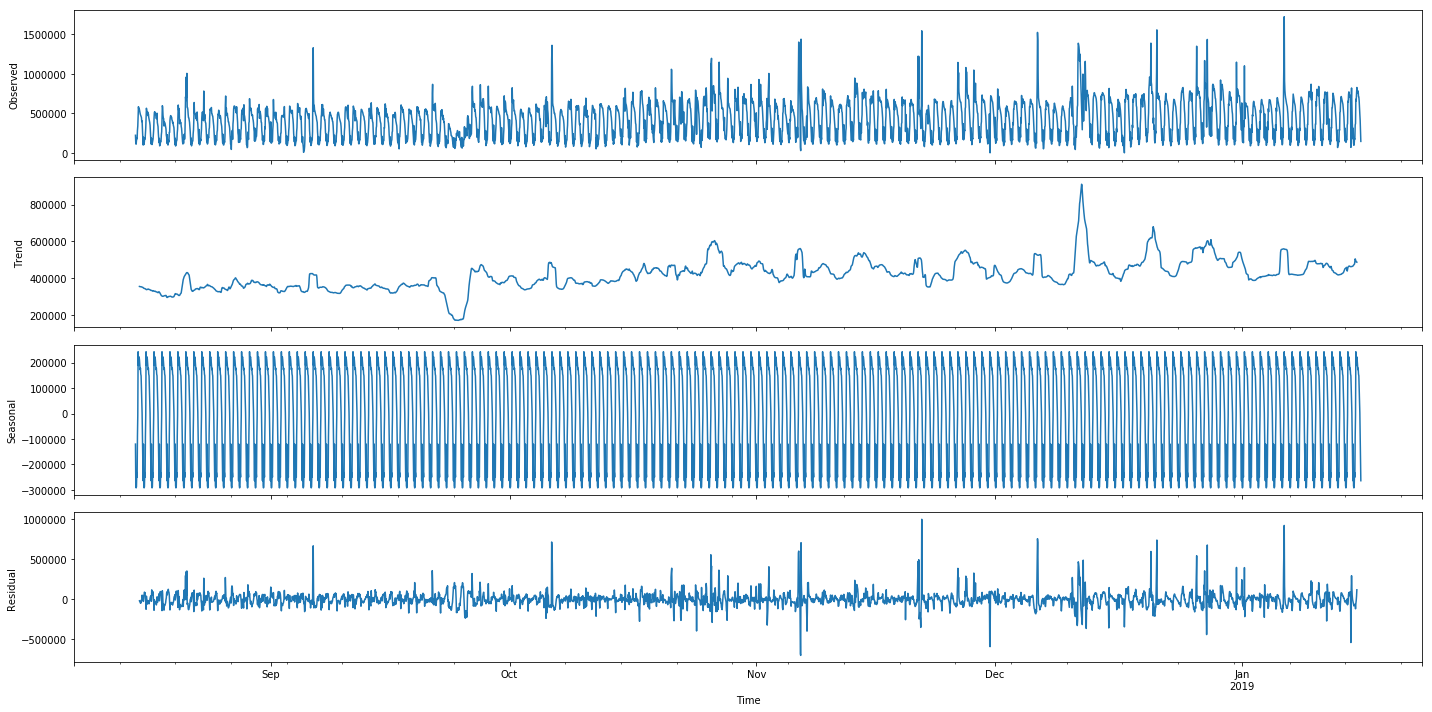

In [71]:
plt.figure(figsize(20,10))
sm.tsa.seasonal_decompose(data).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data)[1])

## Стабилизация дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.485285
Критерий Дики-Фуллера: p=0.000002


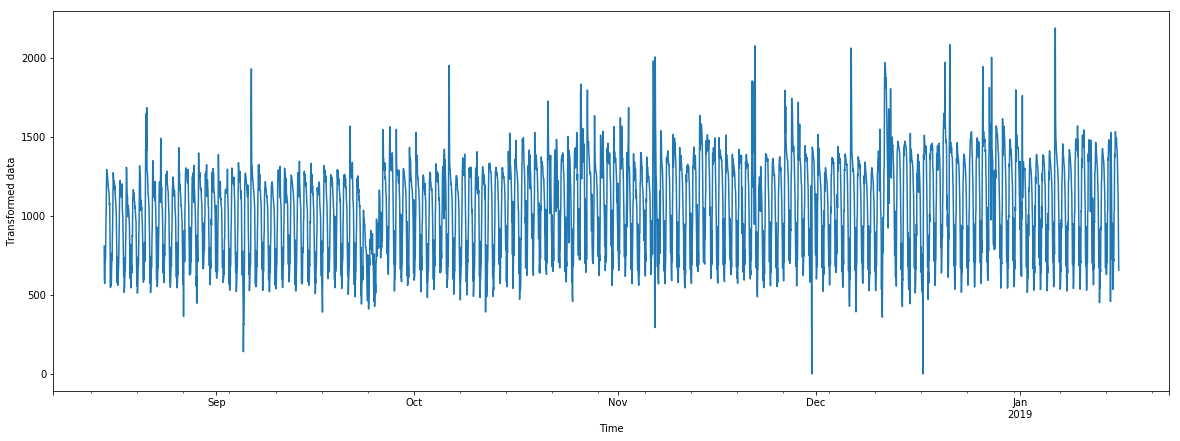

In [72]:
df['Box-Kox'], lmbda = stats.boxcox(df['Value'])
plt.figure(figsize(20,7))
df['Box-Kox'].plot()
plt.ylabel(u'Transformed data')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['Box-Kox'])[1])

### Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден небольшой восходящий тренд. Еще данные колбасит нехило. Проведем сезонное дифференцирование, где сезон равен 24 часам (данные похожи в течении суток); сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность.

In [73]:
SEASON = 24

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

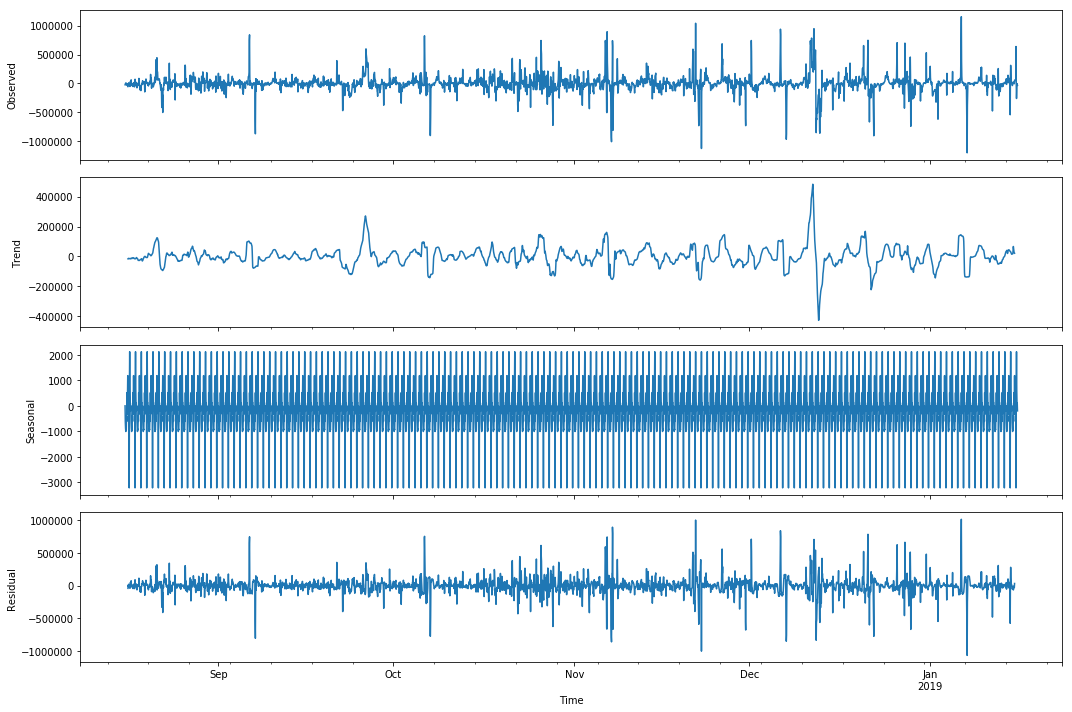

In [74]:
df['Seasonal Diff'] = df['Value'] - df['Value'].shift(SEASON)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df['Seasonal Diff'][SEASON:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['Seasonal Diff'][SEASON:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

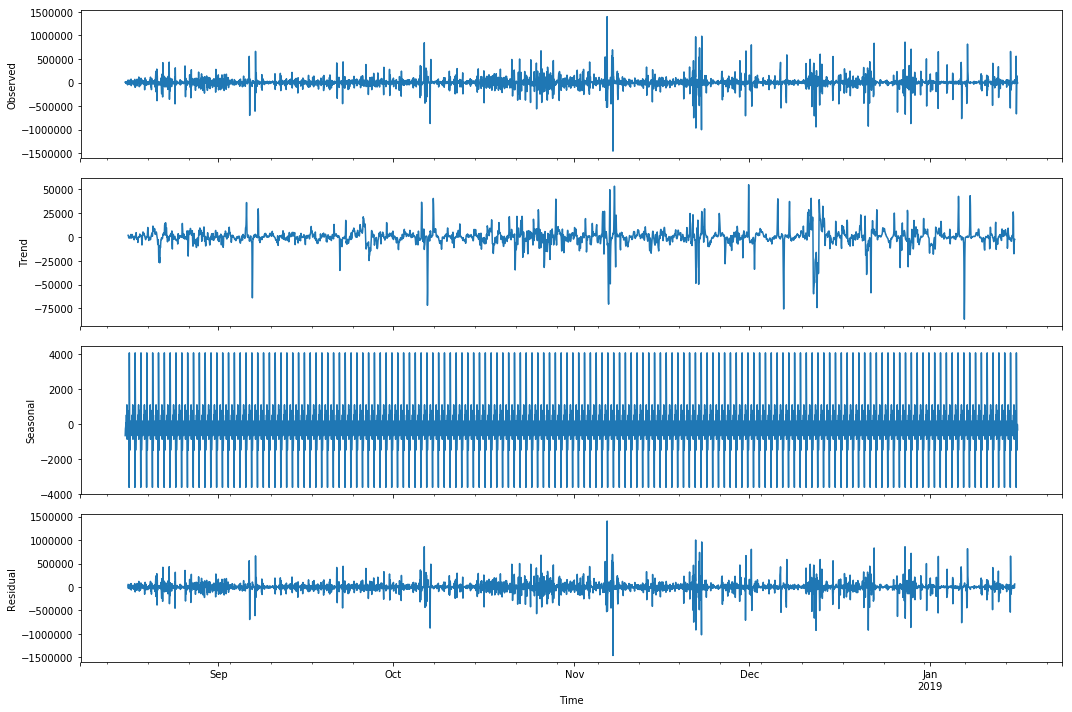

In [75]:
df['Simple Diff'] = df['Seasonal Diff'] - df['Seasonal Diff'].shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df['Simple Diff'][SEASON+1:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['Simple Diff'][SEASON+1:])[1])

###### Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

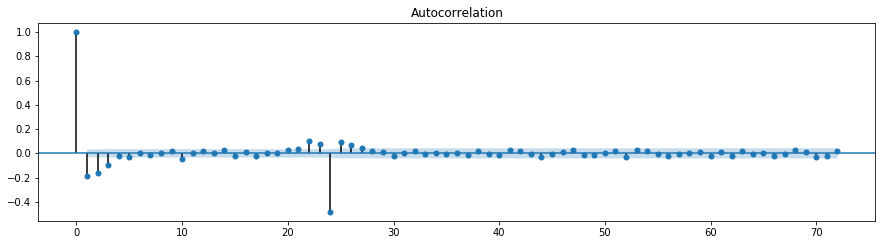

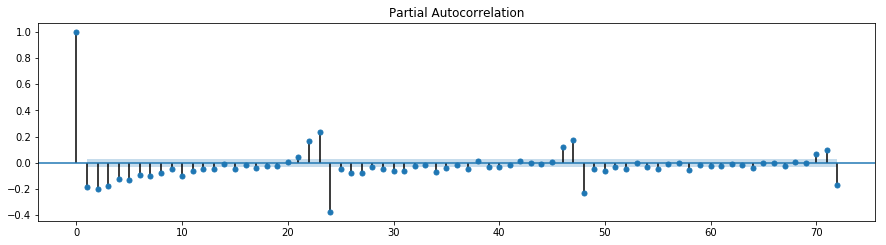

In [76]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df['Simple Diff'][SEASON+1:].values.squeeze(), lags=72, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df['Simple Diff'][SEASON+1:].values.squeeze(), lags=72, ax=ax)
pylab.show()

Общий вид данной модели *ARIMA(p,d,q)(P,D,Q)_s*  
В этой модели параметры обозначают следующее:  
* p — порядок модели AR(p)   
* d — порядок интегрирования исходных данных  
* q — порядок модели LaTeX:MA(q)  
* P — порядок сезонной составляющей SAR(P)  
* D — порядок интегрирования сезонной составляющей  
* Q — порядок сезонной составляющей SMA(Q)  
* s — размерность сезонности(месяц, квартал и т.д.)  

Посмотрим на графики и определим границы парметров:  
* Q = 1 (только 1, 24-й лаг сильно коррелирует с рядом),  
* q = 3 (первые три лага больше остальных),  
* P = 1 (как и в случае с Q),  
* p = 6 (тут разброс) 
* d = D = 1
* s = SEASON = 24


In [77]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [78]:
from itertools import product
parameters =  product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [79]:
%%time
k=0
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    print('Рассматриваем модель № ', k)
    k+=1
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df['Value'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], SEASON)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Рассматриваем модель №  0
Рассматриваем модель №  1
Рассматриваем модель №  2
Рассматриваем модель №  3
Рассматриваем модель №  4
Рассматриваем модель №  5
Рассматриваем модель №  6
Рассматриваем модель №  7
Рассматриваем модель №  8
Рассматриваем модель №  9
Рассматриваем модель №  10
Рассматриваем модель №  11
Рассматриваем модель №  12
Рассматриваем модель №  13
Рассматриваем модель №  14
Рассматриваем модель №  15
Wall time: 4min


Выведем ТОП-5 моделей и их критерие Акаике:

In [81]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
13  (1, 1, 0, 1) 94621.290
15  (1, 1, 1, 1) 94645.117
3   (0, 0, 1, 1) 94706.854
1   (0, 0, 0, 1) 94723.959
5   (0, 1, 0, 1) 94910.838


In [82]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Value   No. Observations:                 3696
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 24)   Log Likelihood              -47306.645
Date:                            Fri, 25 Jan 2019   AIC                          94621.290
Time:                                    10:58:00   BIC                          94646.123
Sample:                                08-15-2018   HQIC                         94630.131
                                     - 01-15-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5607      0.013     41.978      0.000       0.535       0.587
ma.L1         -0.9423      0.009   -103.265      0.000      -0.960      -0.924
ma.S.L24      -0.9428      0.009   -104.524      0.000      -0.960      -0.925
sigma2      1.507e+10    3.6e-13   4.19e+22      0.000    1.51e+10    1.51e+10
===================================================================================
Ljung-Box (Q):                       52.78   Jarque-Bera (JB):            141425.22
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               2.47   Skew:                             2.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.13e+36. Standard errors may be unstable.
"""

Её остатки:

Критерий Стьюдента: p=0.229506
Критерий Дики-Фуллера: p=0.000000


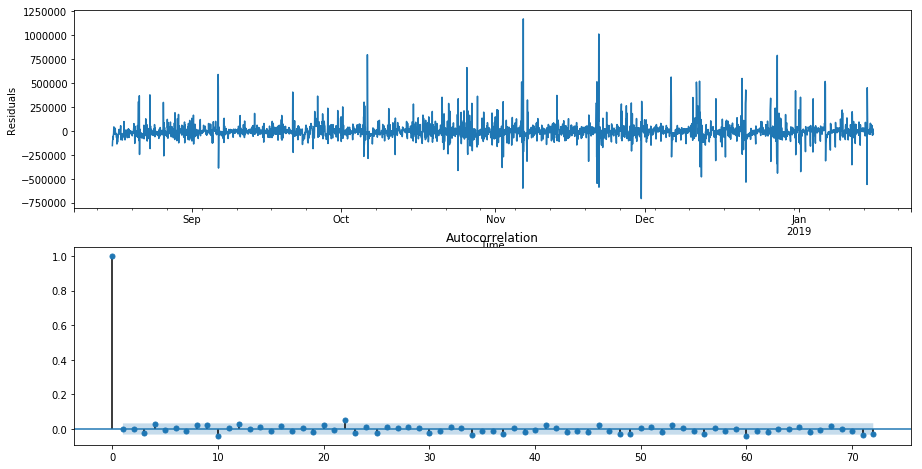

In [83]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[SEASON+1:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[SEASON+1:].values.squeeze(), lags=72, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[SEASON+1:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[SEASON+1:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).  
Посмотрим, насколько хорошо модель описывает данные. Визуализируем месяц:

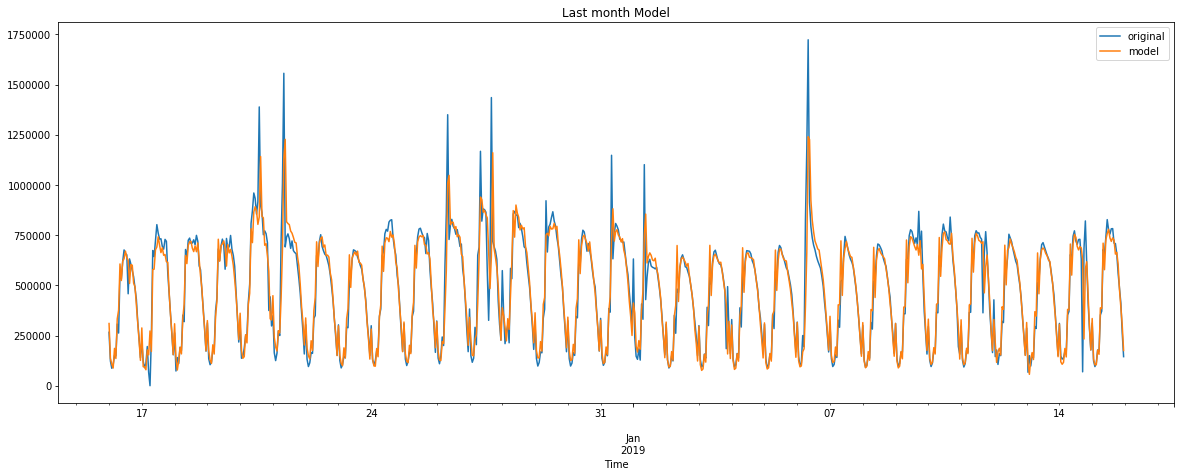

In [84]:
month = 24*31

df['Model'] = best_model.fittedvalues
plt.figure(figsize(20,7))
df['Value'][-month:].plot(label='original')
df['Model'][-month:].plot(label='model')
plt.legend(loc='best')
plt.title('Last month Model')
pylab.show()

А теперь визуализируем меньший интревал - 1 день:

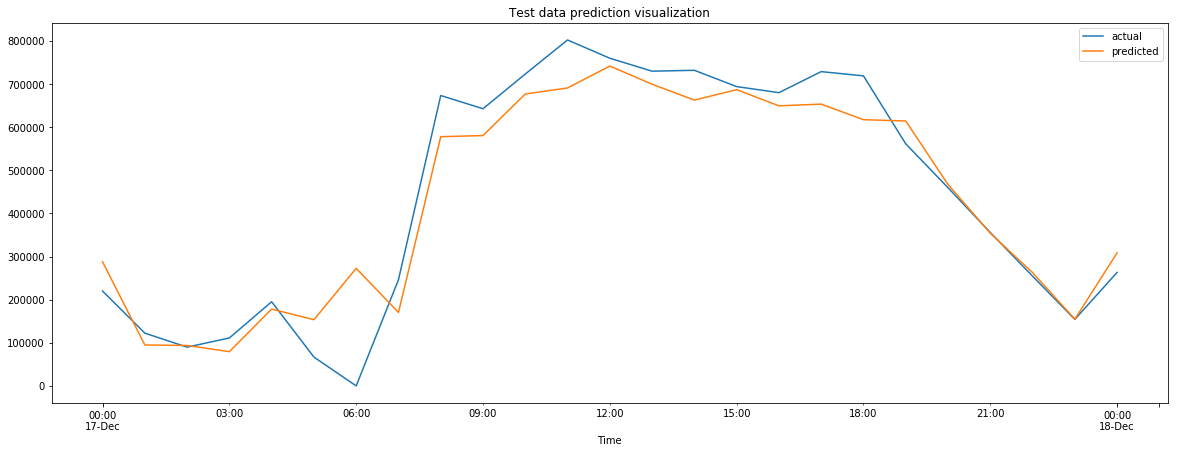

In [85]:
FROM = '2018-12-17 00:00:00'
TO = '2018-12-18 00:00:00'

df['Value'][FROM:TO].plot(label='actual')
df['Model'][FROM:TO].plot(label='predicted')
plt.legend(loc='best')
plt.title('Test data prediction visualization')
plt.show()

### Прогноз

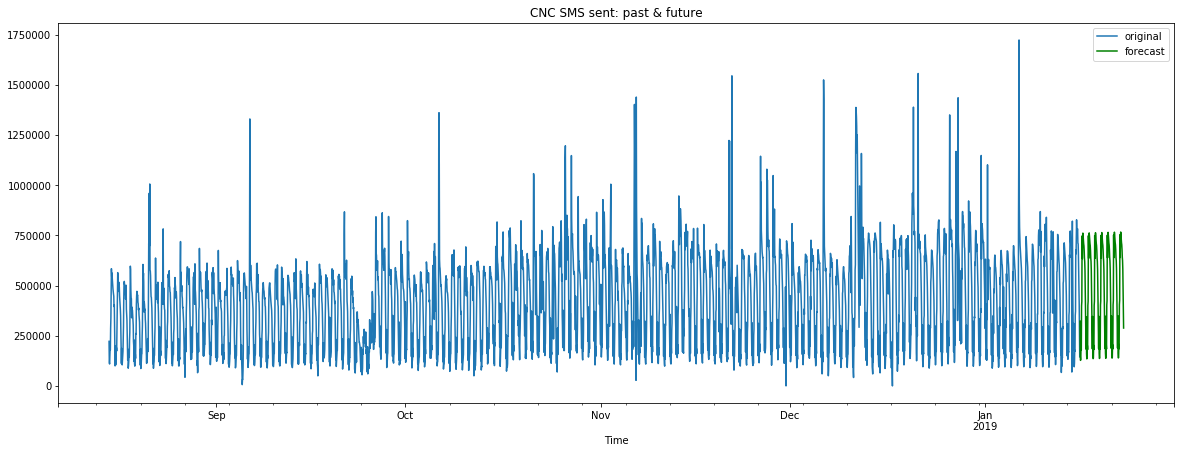

In [86]:
forecast_time = 24*7
last_time = data.tail(1).index[0]

forecast_dates = pd.date_range(start=last_time, periods=forecast_time, freq='1H')

pred = best_model.predict(start=data.size, end=data.size+forecast_time)

forecast=pd.Series(pred, index=forecast_dates)

plt.figure(figsize(20,7))

data.plot(label='original')
forecast.plot(label='forecast',color='green')
plt.title('CNC SMS sent: past & future')
plt.legend(loc='best')
plt.show()